### Multivariate Linear Regression
#### Imports
import all the required libraries

In [24]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import joblib as jb
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from scipy.io import arff

In [25]:
data, meta = arff.loadarff('three_dataset.arff')
df = pd.DataFrame(data)
print(df.head())
print(df.isnull().sum())
print(df.columns.tolist())

   ASM_A_MeanT  ASD_A_SDevT  BSM_B_MeanT  BSD_B_SDevT  CSM_C_MeanT  \
0        -4.86         0.04         0.33         0.13         5.83   
1        -4.86         0.04         0.33         0.13         5.83   
2        -4.86         0.04         0.33         0.13         5.83   
3        -4.68         0.10         0.59         0.17         5.56   
4        -4.68         0.10         0.59         0.17         5.56   

   CSD_C_SDevT  ISM_I_MeanT  ISD_I_SDevT  ALM_A_MeanT  ALD_A_SDevT  \
0         0.15         0.97         0.03        -4.85         0.15   
1         0.15         0.97         0.03        -4.85         0.15   
2         0.15         0.97         0.03        -4.85         0.15   
3         0.14         1.82         0.34        -4.75         0.13   
4         0.14         1.82         0.34        -4.75         0.13   

   BLM_B_MeanT  BLD_B_SDevT  CLM_C_MeanT  CLD_C_SDevT  ILM_I_MeanT  \
0         0.27         0.16         5.67         0.36         1.07   
1         0.27    

the data appears to contain no null values and few inputs contain negative values so it is better to use tanh for activation after normalization

In [33]:
def remove_outliers(df, cols):
    for col in cols:
        q1 = df[col].quantile(0.10)
        q2 = df[col].quantile(0.90)
        iqr = q2 - q1
        lower = q1 - 0.1*iqr
        upper = q2 + 0.1*iqr
        df = df[(df[col] >= lower) & (df[col] <= upper)]
    return df

df = remove_outliers(df, df.columns)

In [50]:
# print(df[['DFlow', 'DGap']].describe())
print(df['DGap'].value_counts())



DGap
-1.0    6
 0.0    5
Name: count, dtype: int64


dflow is completely 0. It has no variance so it is better to drop it as target variable

#### Data cleaning
outliers are removed for a clean data

In [40]:
num_features = df.shape[1]
x = df[['ASM_A_MeanT', 'ASD_A_SDevT', 'BSM_B_MeanT', 'BSD_B_SDevT', 'CSM_C_MeanT', 'CSD_C_SDevT', 'ISM_I_MeanT', 'ISD_I_SDevT', 'ALM_A_MeanT', 'ALD_A_SDevT', 'BLM_B_MeanT', 'BLD_B_SDevT', 'CLM_C_MeanT', 'CLD_C_SDevT', 'ILM_I_MeanT', 'ILD_I_SDevT']].values.reshape(-1,num_features-2)
y = df['DGap'].values.reshape(-1,1)

xs = MinMaxScaler()
ys = MinMaxScaler()

x = xs.fit_transform(x)
y = ys.fit_transform(y)

jb.dump(xs, 'three_x_scaler.pkl')
jb.dump(ys, 'three_y_scaler.pkl')

['three_y_scaler.pkl']

#### Scaling
the input and output features are seperated and are scaled using 2 seperate minmaxscalers

In [42]:
print(num_features)
for i in range(num_features):
    print(", x" + str(i+1), end="")

18
, x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, x11, x12, x13, x14, x15, x16, x17, x18

In [47]:
def prob(x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, x11, x12, x13, x14, x15, x16):
    inp = np.array([[x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, x11, x12, x13, x14, x15, x16]], dtype=float)
    xs = jb.load('three_x_scaler.pkl')
    ys = jb.load('three_y_scaler.pkl')
    model_path = 'three.keras'
    inp = xs.transform(inp)
    if (os.path.exists(model_path)):
        model = keras.models.load_model(model_path)
    else:
        model = keras.Sequential([keras.layers.Dense(32, input_shape=(num_features-2, ), activation='tanh'),
                                  keras.layers.Dense(16, activation='tanh'),
                                  keras.layers.Dense(units=1, activation='linear')])
        model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.01), loss='mean_squared_error')
        h = model.fit(x, y, epochs=400)
        lv = h.history['loss']
        pred = model.predict(x)

        plt.figure()
        plt.plot(lv)
        plt.title('loss values')
        plt.xlabel('Iterations')
        plt.ylabel('loss')
        plt.grid(True)
        plt.show()

        cols = 3
        rows = (num_features+1)//2
        plt.figure(figsize = (cols*5, rows*5))
        output_cols = ['DFlow', 'DGap']
        for i in range(1):
            plt.subplot(rows, cols, i+1)
            plt.scatter(y[:, i], pred[:, i], label='actual vs predicted', color='red')
            plt.plot([y[:, i].min(), y[:, i].max()], [y[:, i].min(), y[:, i].max()], 'k--')
            plt.title(output_cols[i])
            plt.xlabel('atual')
            plt.ylabel('predicted')
            plt.grid(True)
            plt.legend()
        
        plt.tight_layout()
        plt.show()
        model.save('three.keras')
    return ys.inverse_transform(model.predict(inp))[0]


a function for model trainig is created after the training it visualizes the loss curve of the training and also the actual vs predicted output values from the dataset


Epoch 1/400


c:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.4406
Epoch 2/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.3914
Epoch 3/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.3315
Epoch 4/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.2064
Epoch 5/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.1992
Epoch 6/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.2277
Epoch 7/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.2021
Epoch 8/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.1529
Epoch 9/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.1317
Epoch 10/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1414
Epoch 11/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.1471
Epoch 12/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.1301
Epoch 13/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.1045
Epoch 14/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0918
Epoch 15/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0954
Epoch 16/400
1/1 ━━━━━━━━━━━━━━━━

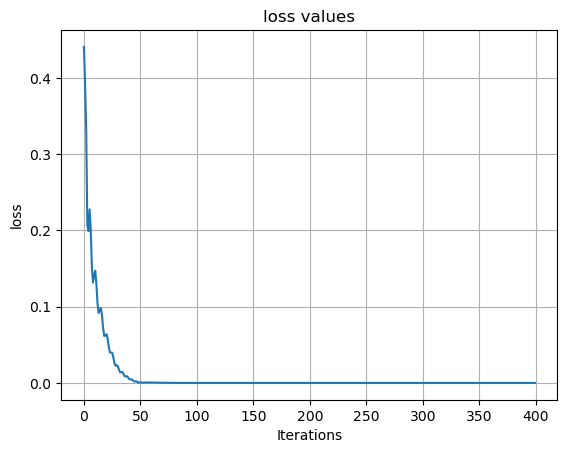

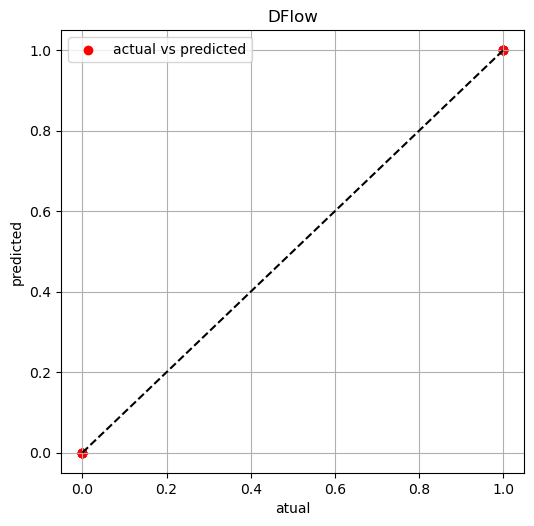

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
[0.69478154]


In [48]:
print(prob(-4.51,0.19,0.98,0.15,5.42,0.23,2.45,0.22,-4.53,0.13,0.97,0.2,5.51,0.27,2.62,0.3))